<a href="https://colab.research.google.com/github/sadidoll/Artifical-Interlligence/blob/master/HW_4/Homework4_p3_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Fine-tuning Xception**
###**Feature extraction**

**Download the data**

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in /tmp.

In [54]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-22 03:24:24--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  56.1MB/s    in 1.2s    

2020-04-22 03:24:26 (56.1 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

###**Build network with Xception convolution base and custom densely connected layers**

**Load the convolutional base**

In [0]:
from keras.applications import Xception

conv_base = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

**Freeze the convolutional base**

In [0]:
conv_base.trainable = False

**Concatenate the convolutional base and densely connected layers**

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [61]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_5 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 33,985,449
Trainable params: 13,123,969
Non-trainable params: 20,861,480
_________________________________

**Train the model end to end with frozen convolutional base**

In [62]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 24s 243ms/step - loss: 0.4551 - acc: 0.7780 - val_loss: 0.0207 - val_acc: 0.9540
Epoch 2/30
100/100 [==============================] - 21s 205ms/step - loss: 0.3832 - acc: 0.8235 - val_loss: 0.1354 - val_acc: 0.9670
Epoch 3/30
100/100 [==============================] - 21s 205ms/step - loss: 0.3529 - acc: 0.8295 - val_loss: 0.0013 - val_acc: 0.9690
Epoch 4/30
100/100 [==============================] - 21s 205ms/step - loss: 0.3229 - acc: 0.8615 - val_loss: 0.1753 - val_acc: 0.9510
Epoch 5/30
100/100 [==============================] - 20s 205ms/step - loss: 0.3297 - acc: 0.8550 - val_loss: 0.2372 - val_acc: 0.9670
Epoch 6/30
100/100 [==============================] - 21s 205ms/step - loss: 0.3188 - acc: 0.8530 - val_loss: 0.0165 - val_acc: 0.9690
Epoch 7/30
100/100 [==============================] - 20s 205ms/step - loss: 0.3157 - acc: 0.8615 - val_lo

**Display curves of loss and accuracy during training**

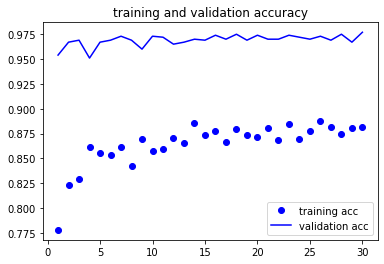

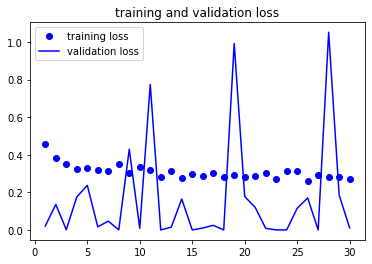

In [63]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

**Fine-tuning**

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block2_speconv2_act':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [65]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 25s 249ms/step - loss: 0.2630 - acc: 0.8895 - val_loss: 0.2796 - val_acc: 0.9400
Epoch 2/30
100/100 [==============================] - 21s 210ms/step - loss: 0.2543 - acc: 0.8915 - val_loss: 0.0499 - val_acc: 0.9450
Epoch 3/30
100/100 [==============================] - 21s 208ms/step - loss: 0.2383 - acc: 0.8990 - val_loss: 0.4036 - val_acc: 0.9310
Epoch 4/30
100/100 [==============================] - 21s 209ms/step - loss: 0.2426 - acc: 0.8915 - val_loss: 0.0521 - val_acc: 0.9360
Epoch 5/30
100/100 [==============================] - 21s 209ms/step - loss: 0.2567 - acc: 0.8885 - val_loss: 0.2053 - val_acc: 0.9390
Epoch 6/30
100/100 [==============================] - 21s 209ms/step - loss: 0.2581 - acc: 0.8930 - val_loss: 0.0645 - val_acc: 0.9260
Epoch 7/30
100/100 [==============================] - 21s 209ms/step - loss: 0.2242 - acc: 0.9140 - val_loss: 0.2937 - val_acc: 0.9370
Epoch 8/30
100/100 [==============================] - 2

**Display learning curves during fine-tuning**

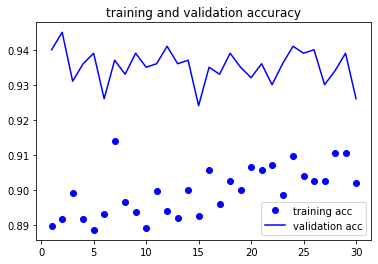

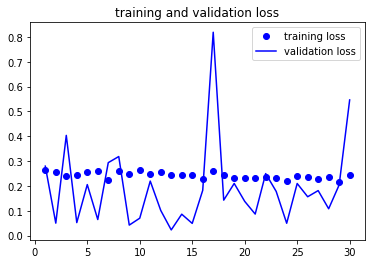

In [66]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

**Print out validation loss and accuracy**

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [68]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.5464187860488892
Validation accuracy: 0.9259999990463257


**The accuracy was definetly better in part1 of the problem 3.**

**Save the model**

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)